In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DR-model.h5')

In [ ]:
model.summary()

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

Saving Sami_rahman.jpg to Sami_rahman.jpg


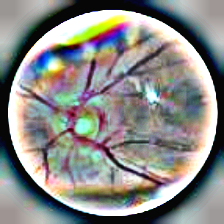

(224, 224, 3)
1/1 [==============================] - 0s 207ms/step
No DR with 97.94274568557739 % confidence


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img = cv2.imread(path)
  img = crop_image_from_gray(img)
  img = cv2.resize(img,(224, 224))
  img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , 10) ,-4 ,128)
  # We first create a CLAHE model based on OpenCV
  #clipLimit defines threshold to limit the contrast in case of noise in our image
  # tileGridSize defines the area size in which local equalization will be performed
  clahe_model = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
  # For ease of understanding, we explicitly equalize each channel individually
  colorimage_b = clahe_model.apply(img[:,:,0])
  colorimage_g = clahe_model.apply(img[:,:,1])
  colorimage_r = clahe_model.apply(img[:,:,2])
  # Next we stack our equalized channels back into a single image
  img = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)
  cv2_imshow(img)
  print(img.shape)
  img = img/255
  img = np.array(img)
  img = img.reshape(-1,224,224,3)
  pred = model.predict(img)
  max_val = pred[0][1]

  for i in range(5):
    if pred[0][i]>max_val:
      max_val = pred[0][i]
      pred_class = i

  if pred_class==0:
    print('No DR with',max_val*100,'% confidence')
  elif pred_class==1:
    print('Mild with',max_val*100,'% confidence')
  elif pred_class==2:
    print('Moderate with',max_val*100,'% confidence')
  elif pred_class==3:
    print('Severe with',max_val*100,'% confidence')
  else:
    print('proliferate with',max_val*100,'% confidence')